# Improved Training of Wasserstein GANs and How to Train Your DRAGAN in Pytorch

Pytorch implementation by Thomas Viehmann, tv@lernapparat.de

## Introduction

Wasserstein GANs have been introduced in [Arjovsky et al: Wasserstein GAN](https://arxiv.org/abs/1701.07875).
There also is a [great summary of the article by Alex Irpan](http://www.alexirpan.com/2017/02/22/wasserstein-gan.html).

Recently, [Gulrajani et al: Improved Training of Wasserstein GANs](https://www.arxiv.org/abs/1704.00028) added a relaxed constraint to the original Wasserstein GAN discriminator training objective. I wrote my take at what is up with that in [Geometric Intuition on Improved Wasserstein GANs](https://lernapparat.de/improved-wasserstein-gan/) and also thought that maybe one could take a step back - namely stick with $|f(x)-f(y)| = |x-y|$ instead of testing $|\nabla f| = 1$ (see the [*Semi-Improved Training of Wasserstein GANs* section](https://lernapparat.de/improved-wasserstein-gan/) for details or the [Notebook](https://github.com/t-vi/pytorch-tvmisc/blob/master/wasserstein-distance/Semi-Improved_Training_of_Wasserstein_GAN.ipynb)).

Update: I have written about [DRAGAN, mistakes in the *semi-improved training* methodology, PRODGAN and SLOGAN](https://lernapparat.de/more-improved-wgan/).

I also include the DRAGAN method of locally (close to the real data) imposing the Lipschitz penalty [Kodali et al: How to Train Your DRAGAN](https://arxiv.org/abs/1705.07215). I provide (my interpretation of) the original sampling procedure for the $\delta$ pertubation (method 4) and my own adaptation using per-model-point standard deviations and a normal randomness (method 5). This is because my impression is that the original sampling is positive only. This observation let me to consider whether it was also possible to just improse the $|\nabla f| = 1$ constraint *on* the real data instead (method 6). I call the latter PRODGAN - Penalty Right On the Data GAN. (Note that PRODGAN is likely not that great an idea, see the linked blog post.)

After some more looking at one-sided penalties, I dubbed the models with one-sided Lipschitz penalty Single-sided Lipschitz Objective GANs or SLOGANs.

Now that pytorch gained support for second derivatives, I wanted to also implement the improved training method directly.

Update: Previous versions reflected that some bits of second derivatives were still missing in master. This is rapidly improving, thanks to the hard work of the pytorch developers.

## Acknowledgement

This is based on the semi-improved notebook, which borrows heavily from the code accompanying the two papers, namely
- https://github.com/martinarjovsky/WassersteinGAN (initialisation, loss calculation and training loop)
- https://github.com/igul222/improved_wgan_training (toy problem data generation and network structure, visualization)
- https://github.com/kodalinaveen3/DRAGAN/ (DRAGAN)

Please see the licenses there and refer to the above when using their code.
I applaud publishing the code with the papers. This was crucial in enabling this exercise.

The first pointer to the DRAGAN I saw was by J. F. Santos sharing [his DRAGAN pytorch implementation](https://github.com/jfsantos/dragan-pytorch) on the Pytorch channel. Thank you!

Adam Paszke of Pytorch helped me with how to do grad of grad and I also learnt a lot from his review of my submission to pytorch autograd.

## Code, code, everone wants code!

Here it is. I have left the semi-improved code in there (`lipschitz_contraint = 1` and `2`), too. Setting `lipschitz_constraint = 3` gets you the improved version, `lipschitz_constraint = 4` the DRAGAN one, `5` DRAGAN with different sampling of the perturbation, `6` PRODGAN

For SLOGAN choose `lipschitz_constraint = 1` or `2` and `one_sided = True`.

I updated the code to be able to specify `lipschitz_constraint`, `onesided` and `penalty_weight` in calls to a training function in order to run several models in an efficient way.

In [157]:
# import everything
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.autograd import Variable
import os
import numpy
import sklearn.datasets

from matplotlib import pyplot
%matplotlib inline
import IPython

In [179]:
# set up parameters, a blend of Wasserstein GAN and Improved Training's code
# to get SLOGAN choose constraint 1 or 2 and opt_onesided = True, other named models use opt_onesided = False

names = ["plain WGAN", "semi-improved WGAN method 1 (WGAN-LP1)", "semi-improved WGAN method 2 (WGAN-LP2)",
         "improved training of WGAN (WGAN-GP)", "DRAGAN", "DRAGAN improved sampling", "PRODGAN"]

opt_lipschitz_constraint = 6 # 0: original WGAN, 1: semi-improved method 1
                          # 2: semi-improved method 2
                          # 3: improved method with gradient penalty
                          # 4: DRAGAN 5: DRAGAN with improved perturbation sampling
                          # 6: PRODGAN

opt_onesided = False     # use two-sided or one-sided constraint

opt_penalty_weight = 10.0 # penalty weight term lambda

opt_dataset = 'swissroll' # 8gaussians | swissroll | 25gaussians
opt_niter = 5000
opt_batchSize=256
opt_lrD = 0.00005 # learning rate for Critic, default=0.00005
opt_lrG = 0.00005 # learning rate for Generator, default=0.00005
opt_beta1=0.5 # beta1 for adam. default=0.5
opt_cuda = True
opt_clamp_lower = -0.01 #default -0.01
opt_clamp_upper =  0.01 #default  0.01
opt_Diters = 10 # number of D iters per each G iter
opt_adam = False  # Whether to use adam (default False is rmsprop)
opt_prefix = None # whether to write images (=prefix of type string) or show in notebook (=None)

opt_manualSeed = 15042017
print("Random Seed: ", opt_manualSeed)
random.seed(opt_manualSeed)
numpy.random.seed(opt_manualSeed)
torch.manual_seed(opt_manualSeed)
cudnn.benchmark = True

Random Seed:  15042017


In [170]:
# Dataset generator largely form Improved Training of Wasserstein GAN code (see link above)
def inf_train_gen(DATASET='8gaussians', BATCH_SIZE=opt_batchSize):
    if DATASET == '25gaussians':
        dataset = []
        for i in range(100000//25):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = numpy.random.randn(2)*0.05
                    point[0] += 2*x
                    point[1] += 2*y
                    dataset.append(point)
        dataset = numpy.array(dataset, dtype='float32')
        numpy.random.shuffle(dataset)
        dataset /= 2.828 # stdev
        while True:
            for i in range(len(dataset)//BATCH_SIZE):
                yield torch.from_numpy(dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE, 
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5 # stdev plus a little
            yield torch.from_numpy(data)

    elif DATASET == '8gaussians':
    
        scale = 2.
        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (1./numpy.sqrt(2), -1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), -1./numpy.sqrt(2))
        ]
        centers = [(scale*x,scale*y) for x,y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = numpy.random.randn(2)*.02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = numpy.array(dataset, dtype='float32')
            dataset /= 1.414 # stdev
            yield torch.from_numpy(dataset)



In [171]:
# Generates and saves a plot of the true distribution, the generator, and the
# critic.
# largely form Improved Training of Wasserstein GAN code (see link above)
class ImageGenerator:
  def __init__(self, netG, netD, prefix='frame', noise_dim=2):
    self.prefix = prefix
    self.frame_index = 1
    self.noise_dim = noise_dim
    self.netG = netG
    self.netD = netD
    
  def __call__(self, true_dist,losses):
    N_POINTS = 128
    RANGE = 3

    points = numpy.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:,:,0] = numpy.linspace(-RANGE, RANGE, N_POINTS)[:,None]
    points[:,:,1] = numpy.linspace(-RANGE, RANGE, N_POINTS)[None,:]
    points = points.reshape((-1,2))
    points = Variable(torch.from_numpy(points).cuda())
    
    noise = torch.FloatTensor().resize_(opt_batchSize, 2)
    noise.normal_(0, 1)
    noise = Variable(noise.cuda())

    fake = self.netG(noise)
    samples = fake.data.cpu().numpy()

    disc_points = self.netD(points)
    
    disc_map = disc_points.data.cpu().numpy()
    
    pyplot.clf()
    if self.prefix is None:
        #pyplot.suplots(nrows=1, ncols=2)
        pyplot.subplot(1,2,1)
    x = y = numpy.linspace(-RANGE, RANGE, N_POINTS)
    pyplot.contour(x,y,disc_map.reshape((len(x), len(y))))

    true_dist = true_dist.cpu().numpy()
    pyplot.scatter(true_dist[:, 0], true_dist[:, 1], c='orange',marker='+')
    pyplot.scatter(samples[:, 0],   samples[:, 1],   c='green', marker='+')
    if self.prefix is not None:
      pyplot.savefig(self.prefix+'{:05d}'.format(self.frame_index)+'.jpg')
    else:
      pyplot.subplot(1,2,2)
      pyplot.plot(losses)
      IPython.display.clear_output(wait=True)
      IPython.display.display(pyplot.gcf())
    self.frame_index += 1


Define the Generator and Critic, I use my own LeakyReLU until second derivatives are available for the standard one.

In [172]:
class MyLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(MyLeakyReLU, self).__init__()
        self.negative_slope = negative_slope
    def forward(self, x):
        return torch.clamp(x, min=0.0)+torch.clamp(x, max=0.0)*self.negative_slope

class ToyGAN_G(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=2, noise_dim=2):
        super(ToyGAN_G, self).__init__()
        self.dim_hidden, self.dim_out, self.noise_dim = dim_hidden, dim_out, noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_out)
            )
    def forward(self, x):
        x = self.net(x)
        return x

class ToyGAN_D(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=2):
        super(ToyGAN_D, self).__init__()
        self.dim_hidden, self.dim_gen_out = dim_hidden, dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            MyLeakyReLU(),
            nn.Linear(dim_hidden, 1)
            )
    def forward(self, x): #?
        x = self.net(x)
        return x


Do the training (code largely taken from Wasserstein GAN code, see link above).
As suspected in an earlier version, there was room for improvement in how to express the loss function in pytorch. A very warm thank you to Adam Paszke for showing the correct way to do it and "live" fixing a bug I hit (if you get `RuntimeError: Cublas_Sgemv only supports m, n, lda, incx, incyin the range 0 < [val] <= 2147483647` you need to update pytorch, too). (Edit: Apparently there also is a bug w.r.t. the output in Jupyter notebook. If the kernel crashes, you might try to convert the code to regular python instead.)

In [182]:
def run_experiment(lipschitz_constraint = opt_lipschitz_constraint,
                   onesided = opt_onesided,
                   penalty_weight = opt_penalty_weight):

    if onesided:
        clip_fn = lambda x: x.clamp(max=0)
    else:
        clip_fn = lambda x: x
    if onesided and (lipschitz_constraint == 1 or lipschitz_constraint == 2):
        name = "SLOGAN simple method {}".format(lipschitz_constraint)
    else:
        name = names[lipschitz_constraint]

    # set up tensors (torch administrativa)
    input = torch.FloatTensor(opt_batchSize, 2)
    input2 = torch.FloatTensor(opt_batchSize, 2)
    interp_alpha = torch.FloatTensor(opt_batchSize, 1)
    noise = torch.FloatTensor(opt_batchSize, 2)
    fixed_noise = torch.FloatTensor(opt_batchSize, 2).normal_(0, 1)
    perturbation = torch.FloatTensor(opt_batchSize,2)
    one = torch.FloatTensor([1])
    mone = one * -1

    if opt_cuda:
        input = input.cuda()
        input2 = input2.cuda()
        interp_alpha = interp_alpha.cuda()
        one, mone = one.cuda(), mone.cuda()
        noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
        perturbation = perturbation.cuda()


    data_generator = inf_train_gen(opt_dataset)
    netD = ToyGAN_D()
    netG = ToyGAN_G()
    netD.cuda()
    netG.cuda()

    generate_image = ImageGenerator(netG, netD, prefix=opt_prefix)

    if opt_adam:
        optimizerD = optim.Adam(netD.parameters(), lr=opt_lrD, betas=(opt_beta1, 0.999))
        optimizerG = optim.Adam(netG.parameters(), lr=opt_lrG, betas=(opt_beta1, 0.999))
    else:
        optimizerD = optim.RMSprop(netD.parameters(), lr = opt_lrD)
        optimizerG = optim.RMSprop(netG.parameters(), lr = opt_lrG)

    losses = []
    for batches in range(opt_niter):
        vinput = Variable(input, requires_grad=(opt_lipschitz_constraint==6))
        vinput2 = Variable(input2)
        vnoise = Variable(noise)
        vfixed_noise = Variable(fixed_noise)


        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if batches < 25 or batches % 500 == 0:
            Diters = 100
        else:
            Diters = opt_Diters
        for j in range(Diters):

            if lipschitz_constraint == 0:
                # clamp parameters to a cube
                for p in netD.parameters():
                    p.data.clamp_(opt_clamp_lower, opt_clamp_upper)

            data = next(data_generator)

            # train with real
            real_cpu = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)
            vinput.data.resize_(real_cpu.size()).copy_(real_cpu)

            errD_real_vec = netD(vinput)
            errD_real = errD_real_vec.mean(0).view(1)
            errD_real.backward(one, retain_graph=(lipschitz_constraint>0))

            # train with fake
            vnoise.data.resize_(batch_size, 2)
            vnoise.data.normal_(0, 1)
            fake = netG(vnoise)
            vinput2.data.resize_(fake.data.size()).copy_(fake.data)
            errD_fake_vec = netD(vinput2)
            errD_fake = errD_fake_vec.mean(0).view(1)
            errD_fake.backward(mone, retain_graph=(lipschitz_constraint>0))
            errD = errD_real - errD_fake
            # These are the various variants
            # Note how we conditionally retained variables and disabled the weight clipping above,
            # possibly not needed for all of them
            if lipschitz_constraint == 1:
                dist = ((vinput-vinput2)**2).sum(1)**0.5
                lip_est = (errD_real_vec-errD_fake_vec).abs()/(dist+1e-8)
                lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
                lip_loss.backward(one)
                errD = errD + lip_loss
            elif lipschitz_constraint == 2:
                interp_alpha.resize_(batch_size, 1)
                interp_alpha.uniform_()
                vinterp_alpha = Variable(interp_alpha)
                dist = ((vinput-vinput2)**2).sum(1)**0.5
                errD_interp_vec = netD(Variable(interp_alpha.expand_as(vinput.data)*vinput.data+(1-interp_alpha.expand_as(vinput.data))*vinput2.data))
                lip_est1 = (errD_fake_vec-errD_interp_vec).abs()/(vinterp_alpha*dist+1e-8)
                lip_est2 = (errD_real_vec-errD_interp_vec).abs()/((1.0-vinterp_alpha)*dist+1e-8)
                lip_loss = 0.5*penalty_weight*((clip_fn(1.0-lip_est1)**2).mean(0).view(1)+(clip_fn(1.0-lip_est2)**2).mean(0).view(1))
                lip_loss.backward(one)
                errD = errD + lip_loss
            elif lipschitz_constraint == 3:           
                interp_alpha.resize_(batch_size, 1)
                interp_alpha.uniform_()
                interp_points = Variable((interp_alpha.expand_as(vinput.data)*vinput.data+(1-interp_alpha.expand_as(vinput.data))*vinput2.data), requires_grad=True)
                errD_interp_vec = netD(interp_points)
                errD_gradient, = torch.autograd.grad(errD_interp_vec.sum(), interp_points, create_graph=True)
                lip_est = (errD_gradient**2).view(batch_size,-1).sum(1)**0.5 # updated: bug fix: added **0.5
                lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
                lip_loss.backward()
                errD = errD + lip_loss
            elif lipschitz_constraint == 4 or lipschitz_constraint == 5:
                if lipschitz_constraint == 4:
                  # this tries to match DRAGAN
                  perturbation.resize_as_(vinput.data)
                  perturbation.uniform_()
                  perturbation *= 0.5*vinput.data.std()
                  interp_alpha.resize_(batch_size, 1)  
                  interp_alpha.uniform_()
                  perturbation *= interp_alpha.expand_as(perturbation)
                else:
                  # the choice of perturbation and leaving out alpha differs from the DRAGAN article
                  perturbation.resize_as_(vinput.data)
                  perturbation.normal_()
                  perturbation *= 0.25*vinput.data.std(0).expand_as(perturbation)

                perturbation += vinput.data
                interp_points = Variable(perturbation, requires_grad=True)
                errD_interp_vec = netD(interp_points)
                errD_gradient, = torch.autograd.grad(errD_interp_vec.sum(), interp_points, create_graph=True)
                lip_est = (errD_gradient**2).view(batch_size,-1).sum(1)**0.5
                lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
                lip_loss.backward()
                errD = errD + lip_loss
            elif lipschitz_constraint == 6:
                errD_gradient, = torch.autograd.grad(errD_real_vec.sum(), vinput, create_graph=True)
                lip_est = (errD_gradient**2).view(batch_size,-1).sum(1)**0.5
                lip_loss = penalty_weight*(clip_fn(1.0-lip_est)**2).mean(0).view(1)
                lip_loss.backward()
                errD = errD + lip_loss
            optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        vnoise.data.resize_(opt_batchSize, 2)
        vnoise.data.normal_(0, 1)
        fake = netG(vnoise)
        errG = netD(fake)
        errG = errG.mean(0).view(1)
        errG.backward(one)
        optimizerG.step()
        if (batches+1) % 50 == 0:
          losses.append(errD.data[0])
          generate_image(data, losses)
          print("Method: {} with penalty weight {}, {}-sided penalty".format(name, penalty_weight, "one" if onesided else "two"))
          print('[%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f Loss_lip %f'
            % (batches, opt_niter,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], lip_loss.data[0]))

    IPython.display.clear_output(wait=True)
    print("Method: {} with penalty weight {}, {}-sided penalty".format(name, penalty_weight, "one" if onesided else "two"))
    print('[%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f Loss_lip %f'
            % (batches, opt_niter,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0], lip_loss.data[0]))


Method: SLOGAN simple method 1 with penalty weight 10, one-sided penalty
[4999/5000] Loss_D: -0.067351 Loss_G: 0.053673 Loss_D_real: -0.010352 Loss_D_fake 0.057000 Loss_lip 0.000000


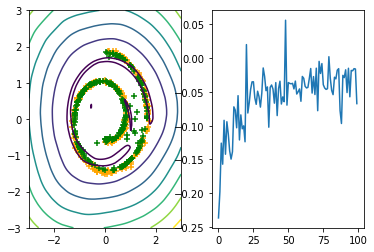

In [183]:
run_experiment(lipschitz_constraint=1, onesided=True, penalty_weight=10)

Method: DRAGAN with penalty weight 10, two-sided penalty
[4999/5000] Loss_D: 0.306053 Loss_G: -4.241849 Loss_D_real: -4.263989 Loss_D_fake -4.275081 Loss_lip 0.294961


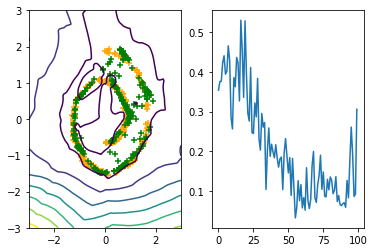

In [184]:
run_experiment(lipschitz_constraint=4, onesided=False, penalty_weight=10)

Method: PRODGAN with penalty weight 10, two-sided penalty
[4999/5000] Loss_D: 0.071838 Loss_G: -1.513794 Loss_D_real: -1.446308 Loss_D_fake -1.480112 Loss_lip 0.038034


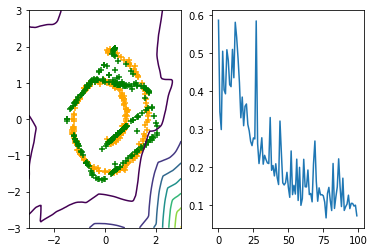

In [185]:
run_experiment(lipschitz_constraint=6, onesided=False, penalty_weight=10)

Method: improved training of WGAN (WGAN-GP) with penalty weight 10, two-sided penalty
[4999/5000] Loss_D: 0.134624 Loss_G: -4.113036 Loss_D_real: -4.248497 Loss_D_fake -3.821264 Loss_lip 0.561857


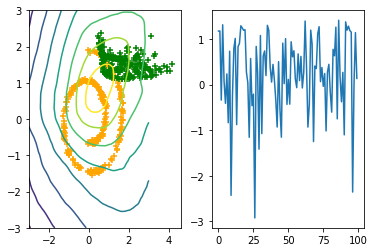

In [188]:
run_experiment(lipschitz_constraint=3, onesided=False, penalty_weight=10)

Method: improved training of WGAN (WGAN-GP) with penalty weight 10, one-sided penalty
[4999/5000] Loss_D: -0.022459 Loss_G: 0.013645 Loss_D_real: 0.000962 Loss_D_fake 0.023864 Loss_lip 0.000443


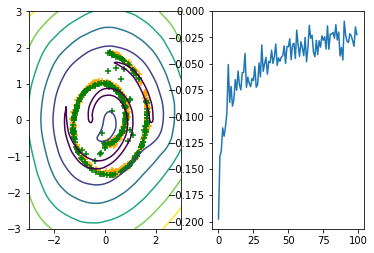

In [187]:
run_experiment(lipschitz_constraint=3, onesided=True, penalty_weight=10)

I have [a small write-up of my conclusions](https://lernapparat.de/more-improved-wgan/).

More things to try:
- Explore why with high penalty, the (semi-) improved WGAN training becomes unstable beyond what is done in the [*more improved training* write-up](https://lernapparat.de/more-improved-wgan/).
- Systematically compare Improved vs. Semi-Improved Training of Wasserstein GAN.
  I am still unsure whether it might be preferrable to have the Lipschitz constant tested directly rather than using the gradient.
  In particular, we can implement a minimally less simple SLOGAN variant.
- Many authors discuss how batch normalisation is not good for GAN. Look at weight normalisation ([Xiang, Li: On the Effects of Batch and Weight Normalization in Generative Adversarial Networks](https://arxiv.org/abs/1704.03971)) and layer normalisation, but maybe beyond the toy examples.


I appreciate your feedback: Thomas Viehmann, tv@lernapparat.de